## Import  Dependencies

In [3]:
import pandas as pd
import cv2 as cv
import torch
import matplotlib.pyplot as plt 
import math
import numpy as np

from tqdm import tqdm

In [4]:
# Ignoring Warnings
import warnings
warnings.filterwarnings('ignore')

## Reading Test Data

In [5]:
test_data = pd.read_csv("test_data.csv")
test_data.LocX = test_data.LocX.str.replace("[" , "").astype("float64")
test_data.LocZ = test_data.LocZ.str.replace("]" , "").astype("float64")
test_data

,Frame,Distance,LocX,LocY,LocZ
0,1,10.588124,6.732110,8.172336,0.0
1,2,10.588965,6.731707,8.173758,0.0
2,3,10.591484,6.730504,8.178010,0.0
3,4,10.595671,6.728504,8.185076,0.0
4,5,10.601518,6.725715,8.194934,0.0
...,...,...,...,...,...
295,296,50.891992,-5.279467,50.617409,0.0
296,297,50.902086,-5.282257,50.627266,0.0
297,298,50.909312,-5.284256,50.634323,0.0
298,299,50.913679,-5.285458,50.638588,0.0


In [6]:
test_data.dtypes

Frame         int64
Distance    float64
LocX        float64
LocY        float64
LocZ        float64
dtype: object

## Installing YOLO

In [7]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
/bin/sh: pip: command not found
requirements: ❌ Command 'pip install --no-cache "gitpython>=3.1.30" "setuptools>=65.5.1" ' returned non-zero exit status 127.
YOLOv5 🚀 2023-9-24 Python-3.9.6 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

### Adding bbox's Centers and Area

In [8]:
center_x = []
center_y = []
area = []

for frame in tqdm(range(1,301)):
    x , y , w , h = model(cv.imread(f"Distance-Test/Test{1:04}.png")).xywh[0][0][:4]
    x , y , w , h = float(x) , float(y) , float(w) , float(h)
    center_x.append((x + (w / 2)))
    center_y.append((y + (h / 2)))
    area.append((w * h))

test_data["Center_x"] = center_x
test_data["Center_y"] = center_y
test_data["Area"] = area



100%|██████████| 300/300 [00:39<00:00,  7.51it/s]


In [9]:
test_data

,Frame,Distance,LocX,LocY,LocZ,Center_x,Center_y,Area
0,1,10.588124,6.732110,8.172336,0.0,1917.631348,721.435577,83800.027439
1,2,10.588965,6.731707,8.173758,0.0,1917.631348,721.435577,83800.027439
2,3,10.591484,6.730504,8.178010,0.0,1917.631348,721.435577,83800.027439
3,4,10.595671,6.728504,8.185076,0.0,1917.631348,721.435577,83800.027439
4,5,10.601518,6.725715,8.194934,0.0,1917.631348,721.435577,83800.027439
...,...,...,...,...,...,...,...,...
295,296,50.891992,-5.279467,50.617409,0.0,1917.631348,721.435577,83800.027439
296,297,50.902086,-5.282257,50.627266,0.0,1917.631348,721.435577,83800.027439
297,298,50.909312,-5.284256,50.634323,0.0,1917.631348,721.435577,83800.027439
298,299,50.913679,-5.285458,50.638588,0.0,1917.631348,721.435577,83800.027439


In [10]:
data = test_data.copy()

# Getting :

### 1.Distance - From Formulas
### 2.Location - From Lookup table

In [14]:
def get_dis_Loc(link : str , look_up_table : pd.core.frame.DataFrame , h_ = 1.6 , f = 1714) -> tuple[float , float , float]:
  """
  Input : Gets Image
  Output : relates it to lookup table and gets LocX and LocY

  """

  d_ , LocX , LocY = 0 , 0 , 0

  link = link
  img = cv.imread(link)
  result = model(img)
  if result.xyxy[0].shape[0] != 0:

    cordinates = result.xywh[0].cpu().numpy()[0]


    Center_x = cordinates[0] + (cordinates[2] / 2)
    Center_y = cordinates[1] + (cordinates[3] / 2)

    d_ = (h_ * f / cordinates[3])
    look_up_table["difference_"] = abs(look_up_table["Distance"] - d_)


    if Center_x > (1920/2):
      data_sub = look_up_table.loc[look_up_table["LocX"] >= 0]


    else:
      data_sub = look_up_table.loc[look_up_table["LocX"] < 0]


    data_sub["Center_x_"] = abs(data_sub["Center_x"] - Center_x)
    data_sub["Center_y_"] = abs(data_sub["Center_y"] - Center_y)
    data_sub["Center_difference_"] = (data_sub["Center_x_"] + data_sub["Center_y_"])/2

    data_min = data_sub["Center_difference_"].idxmin()
    LocX = data.at[data_min , "LocX"]
    LocY = data.at[data_min , "LocY"]

  # If prediction doesnt happen then return prevous data as new (helps in keeping plotting in order)

  return d_ , LocX , LocY

### Setting f and testing the above function

In [15]:
f = (55.2407 * 49.664859) / 1.6
f

1714.7009853508123

In [16]:
d_ , LocX , LocY = get_dis_Loc(link = "Distance-Test/Test0300.png" , look_up_table = data , h_ = 1.6 , f = f)
d_ , LocX , LocY

(53.809223265745786, -0.028754472732543945, 32.0630645751953)

In [17]:
test_data[test_data.Frame == 300]

,Frame,Distance,LocX,LocY,LocZ,Center_x,Center_y,Area
299,300,50.915123,-5.285861,50.639999,0.0,1917.631348,721.435577,83800.027439


# Setting Accuracy function and Metrics

In [18]:
def distance_accuracy(link_short : str , ranges , model , data , h_ = 1.6 , f = 1714):

  """
  Input : Gets shortend link and model to detect object and Lookup table
  Output : Difference between actual and predicted Location and Difference
  """

  dis_diff_dict = {}
  loc_diff_dict = {}
  

  for frame in ranges:
    
    link = f"{link_short}{frame:04d}.png"
    # print("LINK : ",link)
    img = cv.imread(link)
    results = model(img)

    if results.xyxy[0].shape[0] != 0:
      cord = results.xyxy[0].cpu().numpy()[0]
      dis_cord = results.xywh[0].cpu().numpy()[0]

      d_ , LocX , LocY = get_dis_Loc(link = link , look_up_table = data , h_ = h_ , f = f)

      if data[data.Frame == frame].Distance.empty == True: # will return True if the prediction is able to be done in this run but not when lookup table was being built
        pass
      else:
        actual_dis = float(data[data.Frame == frame].Distance)
        actual_locX = data[data.Frame == frame].LocX
        actual_locY = data[data.Frame == frame].LocY

        dis_diff = actual_dis - d_
        loc_diff = float(((actual_locX - LocX) + (actual_locY - LocY)) / 2)

        dis_diff_dict[frame] = dis_diff
        loc_diff_dict[frame] = loc_diff


    else:
      pass
      print(f"Failed to detect at frame : {frame}")



    if img is not None:
      pass
      print(f"Frame analysed : {frame}")
    else:
      pass
      print(f"Frame failed to be analysed {frame}")

  loc_df = pd.DataFrame([loc_diff_dict]).transpose()
  loc_df.columns = ["Location_difference"]

  dis_df = pd.DataFrame([dis_diff_dict]).transpose()
  dis_df.columns = ["Distance_difference"]
    
  return loc_df , dis_df
  

## Analyzing frames and discarding the un-predicted Frames

In [19]:
final_range = 300 + 1
skip = 1

loc_diff_df , dis_diff_df = distance_accuracy(link_short = "Distance-Test/Test" , ranges=range(1,final_range , skip) , model = model , data = data , f = f)

Frame analysed : 1
Frame analysed : 2
Frame analysed : 3
Frame analysed : 4
Frame analysed : 5
Frame analysed : 6
Frame analysed : 7
Frame analysed : 8
Frame analysed : 9
Frame analysed : 10
Frame analysed : 11
Frame analysed : 12
Frame analysed : 13
Frame analysed : 14
Frame analysed : 15
Frame analysed : 16
Frame analysed : 17
Frame analysed : 18
Frame analysed : 19
Frame analysed : 20
Frame analysed : 21
Frame analysed : 22
Frame analysed : 23
Frame analysed : 24
Frame analysed : 25
Frame analysed : 26
Frame analysed : 27
Frame analysed : 28
Frame analysed : 29
Frame analysed : 30
Frame analysed : 31
Frame analysed : 32
Frame analysed : 33
Frame analysed : 34
Frame analysed : 35
Frame analysed : 36
Frame analysed : 37
Frame analysed : 38
Frame analysed : 39
Frame analysed : 40
Frame analysed : 41
Frame analysed : 42
Frame analysed : 43
Frame analysed : 44
Frame analysed : 45
Frame analysed : 46
Frame analysed : 47
Frame analysed : 48
Frame analysed : 49
Frame analysed : 50
Frame ana

In [20]:
loc_diff_df["Frame"] = list(loc_diff_df.index)
dis_diff_df["Frame"] = list(dis_diff_df.index)

In [21]:
data = pd.merge(pd.merge(test_data , loc_diff_df , on = "Frame" , how = "right") , dis_diff_df , on = "Frame" , how = 'right')
data


,Frame,Distance,LocX,LocY,LocZ,Center_x,Center_y,Area,Location_difference,Distance_difference
0,1,10.588124,6.732110,8.172336,0.0,1917.631348,721.435577,83800.027439,0.000000,-1.523898
1,2,10.588965,6.731707,8.173758,0.0,1917.631348,721.435577,83800.027439,0.000510,-1.544170
2,3,10.591484,6.730504,8.178010,0.0,1917.631348,721.435577,83800.027439,0.002034,-1.558544
3,4,10.595671,6.728504,8.185076,0.0,1917.631348,721.435577,83800.027439,0.004567,-1.555693
4,5,10.601518,6.725715,8.194934,0.0,1917.631348,721.435577,83800.027439,0.008102,-1.575423
...,...,...,...,...,...,...,...,...,...,...
282,296,50.891992,-5.279467,50.617409,0.0,1917.631348,721.435577,83800.027439,6.651816,-3.856739
283,297,50.902086,-5.282257,50.627266,0.0,1917.631348,721.435577,83800.027439,6.655349,-2.895738
284,298,50.909312,-5.284256,50.634323,0.0,1917.631348,721.435577,83800.027439,6.657879,-2.978676
285,299,50.913679,-5.285458,50.638588,0.0,1917.631348,721.435577,83800.027439,6.659410,-3.007796


# Plotting 

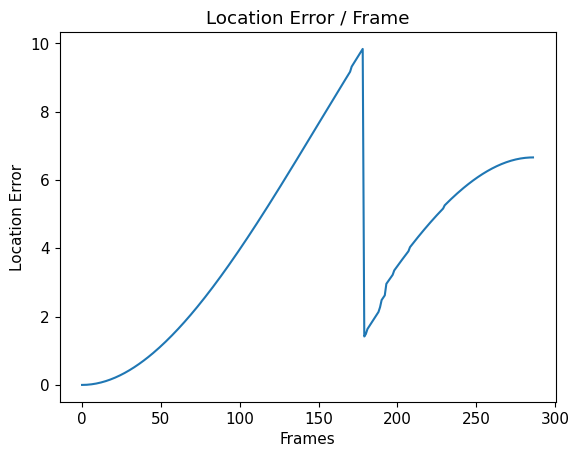

In [22]:
%matplotlib inline

plt.plot(data.Location_difference)
plt.xlabel("Frames")
plt.ylabel("Location Error")
plt.title("Location Error / Frame")
plt.show()

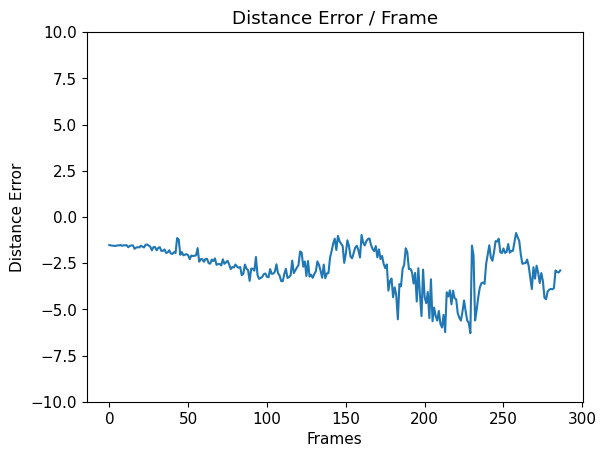

In [23]:
plt.plot(data.Distance_difference)
plt.xlabel("Frames")
plt.ylabel("Distance Error")
plt.title("Distance Error / Frame")
plt.ylim([-10 , 10])
plt.show()

In [24]:
dis_pred = []
LocX_pred = []
LocY_pred = []

for frame in tqdm(range(1,301)):
    d_ , LocX , LocY = get_dis_Loc(link = f"Distance-Test/Test{frame:04}.png" , look_up_table = data , h_ = 1.6 , f = f)
    dis_pred.append(d_)
    LocX_pred.append(LocX)
    LocY_pred.append(LocY)

100%|██████████| 300/300 [00:40<00:00,  7.44it/s]


In [25]:
def patch_prev(List : list , find , replace = None):
    """
    Replaces the "find" with the previous value
    """
    track = None
    for index in range(len(List)):
        if List[index] == find:
            if index == 0:
                raise Exception("First index cannot be the one to replace")
            else:
                if replace is None:
                    List[index] = track
                else:
                    List[index] = replace
        
        track = List[index]
    return List

In [26]:
dis_pred = patch_prev(dis_pred , find = 0)[:287]
LocX_pred = patch_prev(LocX_pred , find = 0)[:287]
LocY_pred = patch_prev(LocY_pred , find = 0)[:287]


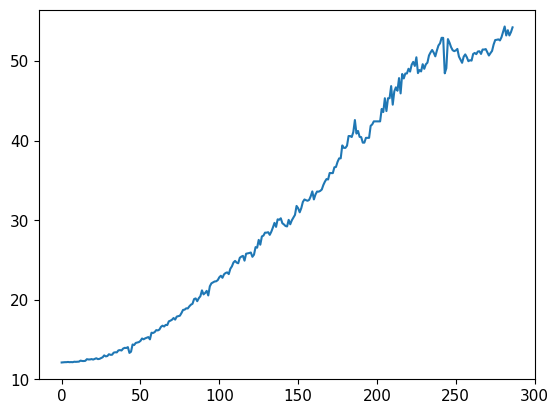

In [27]:
plt.plot(dis_pred)

Text(0, 0.5, 'LocY')

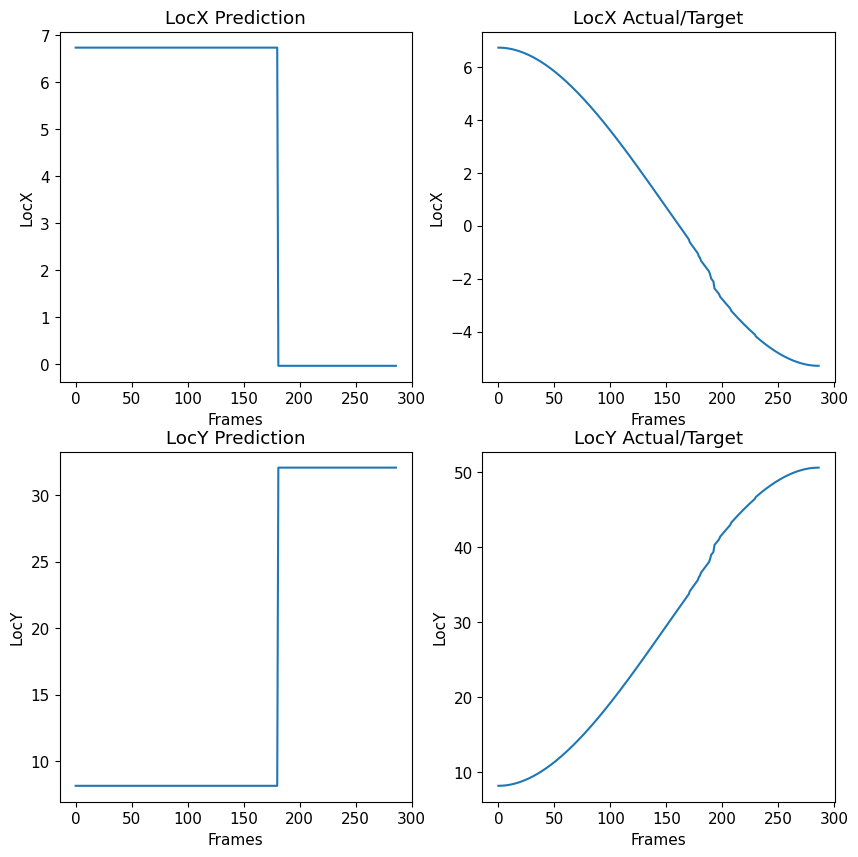

In [44]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(LocX_pred)
plt.title("LocX Prediction")
plt.xlabel("Frames")
plt.ylabel("LocX")

plt.subplot(2,2,2)
plt.plot(data.LocX)
plt.title("LocX Actual/Target")
plt.xlabel("Frames")
plt.ylabel("LocX")

plt.subplot(2,2,3)
plt.plot(LocY_pred)
plt.title("LocY Prediction")
plt.xlabel("Frames")
plt.ylabel("LocY")

plt.subplot(2,2,4)
plt.plot(data.LocY)
plt.title("LocY Actual/Target")
plt.xlabel("Frames")
plt.ylabel("LocY")

In [32]:
dis_pred_arr = np.asarray(dis_pred) - 2
dis_pred_arr

array([     10.112,      10.133,       10.15,      10.151,      10.177,       10.15,      10.163,      10.148,      10.205,      10.191,      10.209,      10.221,      10.348,      10.299,      10.293,      10.316,      10.524,      10.489,      10.493,      10.538,      10.479,       10.56,      10.645,      10.533,
            10.565,      10.658,      10.763,      11.006,      10.876,      10.925,      11.148,      11.077,      11.083,      11.346,      11.396,      11.381,       11.63,      11.668,       11.62,      11.861,      11.953,       11.93,      12.045,      11.316,      11.464,      12.376,      12.309,      12.569,
            12.617,      12.676,      12.829,      13.128,      13.026,      13.147,       13.23,      13.306,       13.02,      13.852,      13.821,      13.931,      14.181,       14.14,       14.25,      14.594,      14.738,      14.634,       14.84,      14.815,      15.289,      15.369,      15.489,      15.705,
            15.503,      15.883,       15.9

In [33]:
dis_arr = np.asarray(data.Distance)
dis_arr

array([     10.588,      10.589,      10.591,      10.596,      10.602,      10.609,      10.618,      10.629,      10.641,      10.656,      10.671,      10.689,      10.708,      10.728,      10.751,      10.775,      10.801,      10.828,      10.857,      10.888,       10.92,      10.955,      10.991,      11.028,
            11.068,      11.109,      11.152,      11.197,      11.244,      11.292,      11.343,      11.395,      11.449,      11.505,      11.563,      11.622,      11.684,      11.748,      11.813,       11.88,       11.95,      12.021,      12.094,       12.17,      12.247,      12.326,      12.407,       12.49,
            12.576,      12.663,      12.752,      12.843,      12.936,      13.031,      13.128,      13.227,      13.329,      13.432,      13.537,      13.644,      13.753,      13.864,      13.977,      14.092,      14.208,      14.327,      14.448,       14.57,      14.695,      14.821,      14.949,      15.079,
            15.211,      15.345,       15.4

In [34]:
len(dis_pred_arr) , len(data.Distance)

(287, 287)

In [35]:
major_err = {}
dis_err_thres = 1.5

for frame in range(len(dis_arr)):
    error = dis_pred_arr[frame] - dis_arr[frame]
    if abs(error) >= dis_err_thres:
        major_err[frame] = error

In [36]:
len(major_err)

31

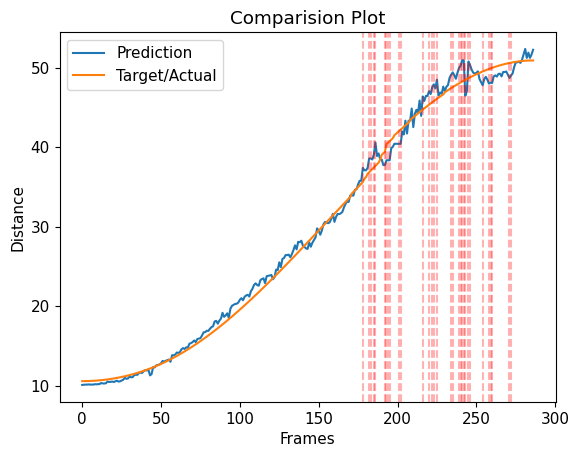

In [37]:
plt.plot(dis_pred_arr , label = "Prediction")
plt.plot(dis_arr , label = "Target/Actual")

for err_frame in major_err:
    plt.axvline(x = err_frame, color = 'r', linestyle = 'dashed' , alpha = 0.3 )
plt.xlabel("Frames")
plt.ylabel("Distance")
plt.title("Comparision Plot")
plt.legend()